# Exploratory Data Analysis

Using the recently completed runs from wandb to generate insights and figures for upcoming journal publication

In [1]:
import os
os.getcwd()

import wandb
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Image

In [2]:
import pandas as pd
import wandb
from dotenv import load_dotenv
load_dotenv()
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("andberg9-self/Unbearable-Weight-Results")

summary_list, config_list, name_list = [], [], []
for run in runs:
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
          if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list
    })

runs_df.to_csv("project.csv")

In [3]:
display(len(runs_df))
display(runs_df.head())



70

,summary,config,name
0,"{'_runtime': 625.574689811, '_step': 308, '_ti...","{'model_type': 'resnet18', 'loss_config': 'typ...",resnet18-full-0augs
1,"{'_runtime': 1958.920681965, '_step': 308, '_t...","{'model_type': 'resnet18', 'loss_config': 'typ...",resnet18-full-3augs
2,"{'_runtime': 694.711207529, '_step': 308, '_ti...","{'model_type': 'resnet18', 'loss_config': 'typ...",resnet18-classifier-0augs
3,"{'_runtime': 1774.837933873, '_step': 308, '_t...","{'model_type': 'resnet18', 'loss_config': 'typ...",resnet18-classifier-3augs
4,"{'_runtime': 832.59192502, '_step': 308, '_tim...","{'model_type': 'resnet18', 'loss_config': 'typ...",resnet18-ssf-0augs


In [4]:
# model_type = runs_df['config']['model_type']
model_type = runs_df['config'][0]['model_type']
display(model_type)
summarys = runs_df['summary']
# display(summarys[0])
final_average_val_acc = summarys[0]['final_average_val_acc']
display(final_average_val_acc)

final_average_val_std = summarys[0]['final_std_val_acc']
display(final_average_val_std)


'resnet18'

0.956129002571106

0.012172887489089464

In [5]:
# simply DataFrame w/ model_name 
import re
name_list = []
for i in range(0, len(runs_df)):
    name = runs_df['name'][i]
    model_name = re.search(r'\w+', name)
    if model_name.group(0) not in name_list:
        name_list.append(model_name.group(0))
        runs_df['model_name'] = model_name.group(0)
display(runs_df.head())


,summary,config,name,model_name
0,"{'_runtime': 625.574689811, '_step': 308, '_ti...","{'model_type': 'resnet18', 'loss_config': 'typ...",resnet18-full-0augs,vit_base
1,"{'_runtime': 1958.920681965, '_step': 308, '_t...","{'model_type': 'resnet18', 'loss_config': 'typ...",resnet18-full-3augs,vit_base
2,"{'_runtime': 694.711207529, '_step': 308, '_ti...","{'model_type': 'resnet18', 'loss_config': 'typ...",resnet18-classifier-0augs,vit_base
3,"{'_runtime': 1774.837933873, '_step': 308, '_t...","{'model_type': 'resnet18', 'loss_config': 'typ...",resnet18-classifier-3augs,vit_base
4,"{'_runtime': 832.59192502, '_step': 308, '_tim...","{'model_type': 'resnet18', 'loss_config': 'typ...",resnet18-ssf-0augs,vit_base


In [6]:
# Extract data for violin plot
import ast
import re

# Create lists to store the data
model_names = []
accuracies = []
std_devs = []
config_types = []
aug_levels = []

for i in range(len(runs_df)):
    # Get the summary data
    summary = runs_df['summary'][i]
    name = runs_df['name'][i]
    config = runs_df['config'][i]
    
    # Extract accuracy and std dev
    if 'final_average_val_acc' in summary:
        accuracy = summary['final_average_val_acc']
        std_dev = summary['final_std_val_acc']
        
        # Extract model type from config
        model_type = config['model_type']
        
        # Extract configuration type and augmentation level from name
        # Parse name like "resnet18-full-0augs" or "vit-ssf-3augs"
        name_parts = name.split('-')
        print(name_parts)
        if len(name_parts) >= 3:
            config_type = name_parts[1]  # full, classifier, ssf, etc.
            aug_level = config['augmentation_config']['augmentations_per_sample']     # 0augs, 3augs, etc.
            # aug_level = re.findall(r'\d+', aug_part)[0] if re.findall(r'\d+', aug_part) else '0'
        else:
            config_type = 'unknown'
            aug_level = '0'
        
        model_names.append(model_type)
        accuracies.append(accuracy)
        std_devs.append(std_dev)
        config_types.append(config_type)
        aug_levels.append(aug_level)

# Create a DataFrame for easier plotting
plot_df = pd.DataFrame({
    'model': model_names,
    'accuracy': accuracies,
    'std_dev': std_devs,
    'config_type': config_types,
    'aug_level': aug_levels,
    'model_config': [f"{m}-{c}" for m, c in zip(model_names, config_types)]
})

print(f"Total runs: {len(plot_df)}")
print(f"Unique models: {plot_df['model'].unique()}")
print(f"Unique config types: {plot_df['config_type'].unique()}")
print(f"Unique augmentation levels: {plot_df['aug_level'].unique()}")
display(plot_df.head())


['resnet18', 'full', '0augs']
['resnet18', 'full', '3augs']
['resnet18', 'classifier', '0augs']
['resnet18', 'classifier', '3augs']
['resnet18', 'ssf', '0augs']
['resnet18', 'ssf', '3augs']
['resnet18', 'batchnorm', '0augs']
['resnet18', 'batchnorm', '3augs']
['resnet152', 'full', '0augs']
['resnet152', 'full', '3augs']
['resnet152', 'classifier', '0augs']
['resnet152', 'classifier', '3augs']
['resnet152', 'ssf', '0augs']
['resnet152', 'ssf', '3augs']
['resnet152', 'batchnorm', '0augs']
['resnet152', 'batchnorm', '3augs']
['mobilenet_v3_small', 'full', '0augs']
['mobilenet_v3_small', 'full', '3augs']
['mobilenet_v3_small', 'classifier', '0augs']
['mobilenet_v3_small', 'classifier', '3augs']
['mobilenet_v3_small', 'ssf', '0augs']
['mobilenet_v3_small', 'ssf', '3augs']
['mobilenet_v3_small', 'batchnorm', '0augs']
['mobilenet_v3_small', 'batchnorm', '3augs']
['mobilenet_v3_large', 'full', '0augs']
['mobilenet_v3_large', 'full', '3augs']
['mobilenet_v3_large', 'classifier', '0augs']
['mobi

,model,accuracy,std_dev,config_type,aug_level,model_config
0,resnet18,0.956129,0.012173,full,0,resnet18-full
1,resnet18,0.969677,0.006797,full,3,resnet18-full
2,resnet18,0.861290,0.023440,classifier,0,resnet18-classifier
3,resnet18,0.863871,0.020821,classifier,3,resnet18-classifier
4,resnet18,0.916774,0.014412,ssf,0,resnet18-ssf


In [7]:
import datetime
# Extract _runtime for each run and add as a new column to plot_df
plot_df['runtime'] = [runs_df['summary'][i]['_runtime'] for i in range(len(runs_df))]
# add a convert hhmmss to seconds column
plot_df['runtime_hhmmss'] = plot_df['runtime'].apply(lambda x: datetime.timedelta(seconds=x))
total_seconds = plot_df['runtime'].sum()
total_runtime = datetime.timedelta(seconds=total_seconds)

In [8]:
# remove outliers from std_dev and accuracy
plot_df = plot_df[plot_df['std_dev'] < 0.1]
plot_df = plot_df[plot_df['accuracy'] > 0.5]


In [9]:
# Helper functions for plotting
def get_ordered_categories(df, group_col, value_col):
    """Get ordered categories by mean value (descending)"""
    order = (
        df.groupby(group_col)[value_col]
        .mean()
        .sort_values(ascending=False)
        .index
        .tolist()
    )
    return order

def add_min_max_annotations(ax, df, x_col, y_col, order):
    """Add min/max annotations to violin plots"""
    for i, category in enumerate(order):
        category_data = df[df[x_col] == category][y_col]
        if len(category_data) > 0:
            min_val = category_data.min()
            max_val = category_data.max()
            
            # Add min annotation (red triangle pointing down)
            ax.scatter(i, min_val, color='red', marker='v', s=50, zorder=10)
            ax.annotate(f'{min_val:.3f}', (i, min_val), 
                       xytext=(5, -15), textcoords='offset points',
                       fontsize=8, color='red', weight='bold',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))
            
            # Add max annotation (green triangle pointing up)
            ax.scatter(i, max_val, color='green', marker='^', s=50, zorder=10)
            ax.annotate(f'{max_val:.3f}', (i, max_val), 
                       xytext=(5, 10), textcoords='offset points',
                       fontsize=8, color='green', weight='bold',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))


/var/folders/wt/0cctqrvs30s8k5gxwkvs86j80000gn/T/ipykernel_25553/369530149.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=plot_df, x='model', y='accuracy', ax=ax, palette='Set2', order=model_order)


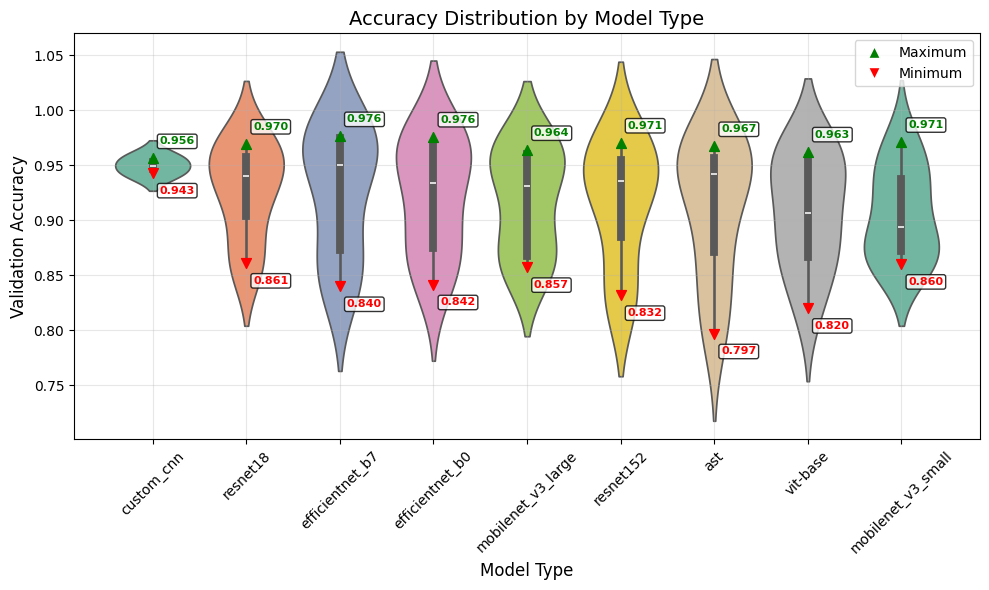

In [10]:
# Plot 1: Accuracy distribution by model type (ordered)
plt.style.use('default')
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

model_order = get_ordered_categories(plot_df, 'model', 'accuracy')
sns.violinplot(data=plot_df, x='model', y='accuracy', ax=ax, palette='Set2', order=model_order)
add_min_max_annotations(ax, plot_df, 'model', 'accuracy', model_order)

ax.set_title('Accuracy Distribution by Model Type', fontsize=14)
ax.set_xlabel('Model Type', fontsize=12)
ax.set_ylabel('Validation Accuracy', fontsize=12)
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3)

# Add legend for min/max markers
legend_elements = [
    plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='green', markersize=8, label='Maximum'),
    plt.Line2D([0], [0], marker='v', color='w', markerfacecolor='red', markersize=8, label='Minimum')
]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.savefig('accuracy_by_model_type.png', dpi=300, bbox_inches='tight')
plt.show()


/var/folders/wt/0cctqrvs30s8k5gxwkvs86j80000gn/T/ipykernel_25553/1886043102.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=plot_df, x='config_type', y='accuracy', ax=ax, palette='Set1', order=config_order)


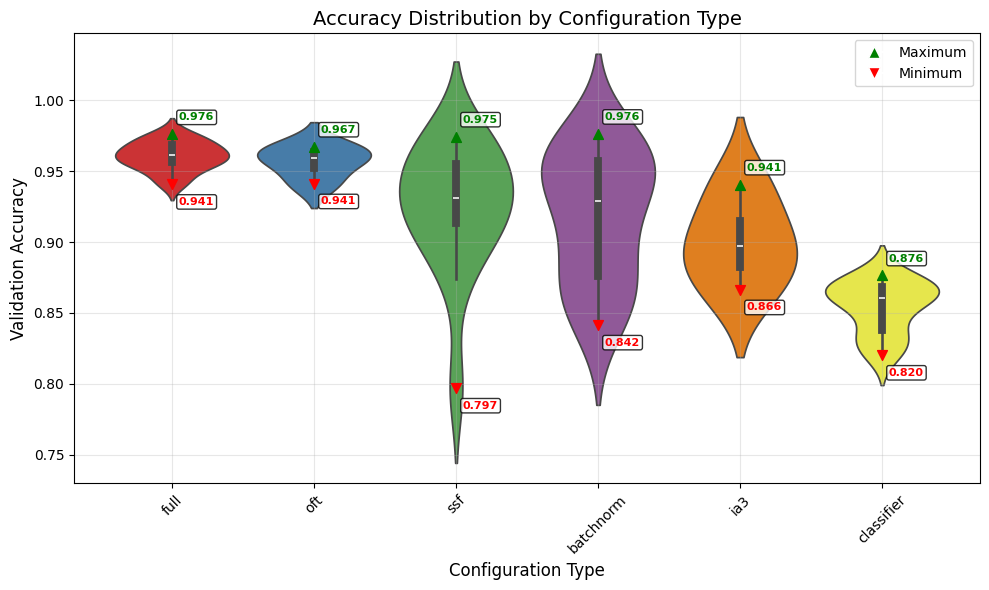

In [11]:
# Plot 2: Accuracy distribution by configuration type (ordered)
plt.style.use('default')
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

config_order = get_ordered_categories(plot_df, 'config_type', 'accuracy')
sns.violinplot(data=plot_df, x='config_type', y='accuracy', ax=ax, palette='Set1', order=config_order)
add_min_max_annotations(ax, plot_df, 'config_type', 'accuracy', config_order)

ax.set_title('Accuracy Distribution by Configuration Type', fontsize=14)
ax.set_xlabel('Configuration Type', fontsize=12)
ax.set_ylabel('Validation Accuracy', fontsize=12)
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3)

# Add legend for min/max markers
legend_elements = [
    plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='green', markersize=8, label='Maximum'),
    plt.Line2D([0], [0], marker='v', color='w', markerfacecolor='red', markersize=8, label='Minimum')
]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.savefig('accuracy_by_config_type.png', dpi=300, bbox_inches='tight')
plt.show()


/var/folders/wt/0cctqrvs30s8k5gxwkvs86j80000gn/T/ipykernel_25553/4063966452.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=plot_df, x='model', y='std_dev', ax=ax, palette='Set3', order=model_order)


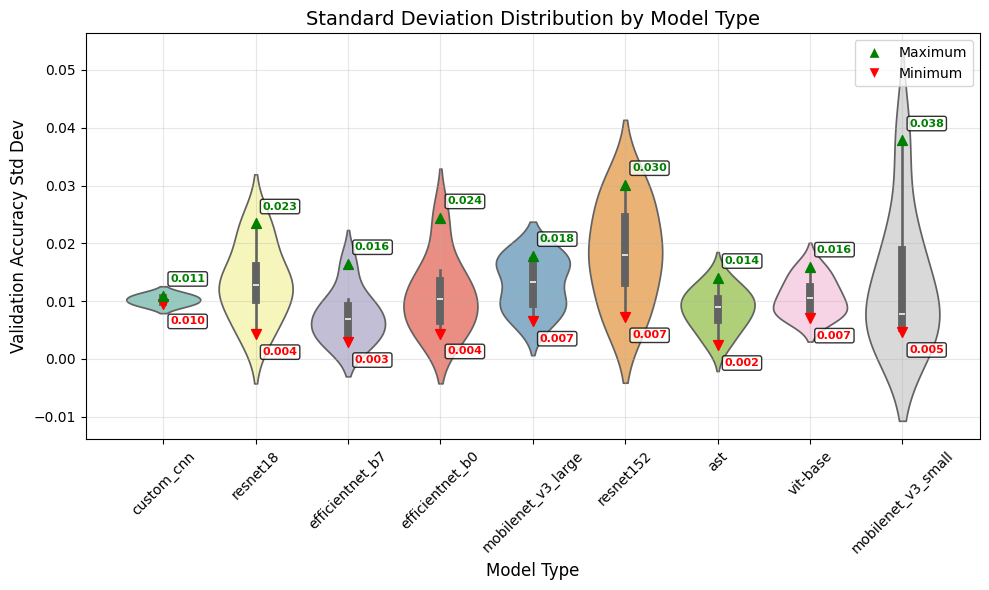

In [12]:
# Plot 3: Standard deviation distribution by model type (ordered by mean accuracy)
plt.style.use('default')
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Use the same model_order as above for consistency
model_order = get_ordered_categories(plot_df, 'model', 'accuracy')
sns.violinplot(data=plot_df, x='model', y='std_dev', ax=ax, palette='Set3', order=model_order)
add_min_max_annotations(ax, plot_df, 'model', 'std_dev', model_order)

ax.set_title('Standard Deviation Distribution by Model Type', fontsize=14)
ax.set_xlabel('Model Type', fontsize=12)
ax.set_ylabel('Validation Accuracy Std Dev', fontsize=12)
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3)

# Add legend for min/max markers
legend_elements = [
    plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='green', markersize=8, label='Maximum'),
    plt.Line2D([0], [0], marker='v', color='w', markerfacecolor='red', markersize=8, label='Minimum')
]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.savefig('std_dev_by_model_type.png', dpi=300, bbox_inches='tight')
plt.show()


/var/folders/wt/0cctqrvs30s8k5gxwkvs86j80000gn/T/ipykernel_25553/3319481731.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=plot_df, x='aug_level', y='accuracy', ax=ax, palette='viridis', order=aug_order)


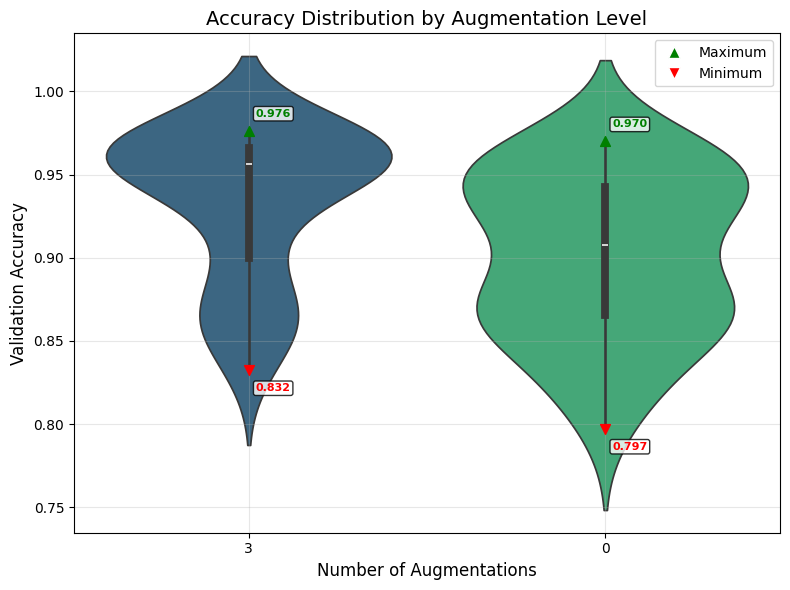

In [13]:
# Plot 4: Accuracy vs augmentation level (ordered)
plt.style.use('default')
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# For aug_level, ensure it's sorted by mean accuracy, but keep as string for x-axis
aug_order = get_ordered_categories(plot_df, 'aug_level', 'accuracy')
sns.violinplot(data=plot_df, x='aug_level', y='accuracy', ax=ax, palette='viridis', order=aug_order)
add_min_max_annotations(ax, plot_df, 'aug_level', 'accuracy', aug_order)

ax.set_title('Accuracy Distribution by Augmentation Level', fontsize=14)
ax.set_xlabel('Number of Augmentations', fontsize=12)
ax.set_ylabel('Validation Accuracy', fontsize=12)
ax.grid(True, alpha=0.3)

# Add legend for min/max markers
legend_elements = [
    plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='green', markersize=8, label='Maximum'),
    plt.Line2D([0], [0], marker='v', color='w', markerfacecolor='red', markersize=8, label='Minimum')
]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.savefig('accuracy_by_augmentation_level.png', dpi=300, bbox_inches='tight')
plt.show()


In [14]:
# Alternative plots without min/max annotations (simpler versions)
# These provide cleaner visualizations without the detailed annotations


/var/folders/wt/0cctqrvs30s8k5gxwkvs86j80000gn/T/ipykernel_25553/3377652487.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=plot_df, x='model', y='accuracy', ax=ax, palette='Set2', order=model_order)


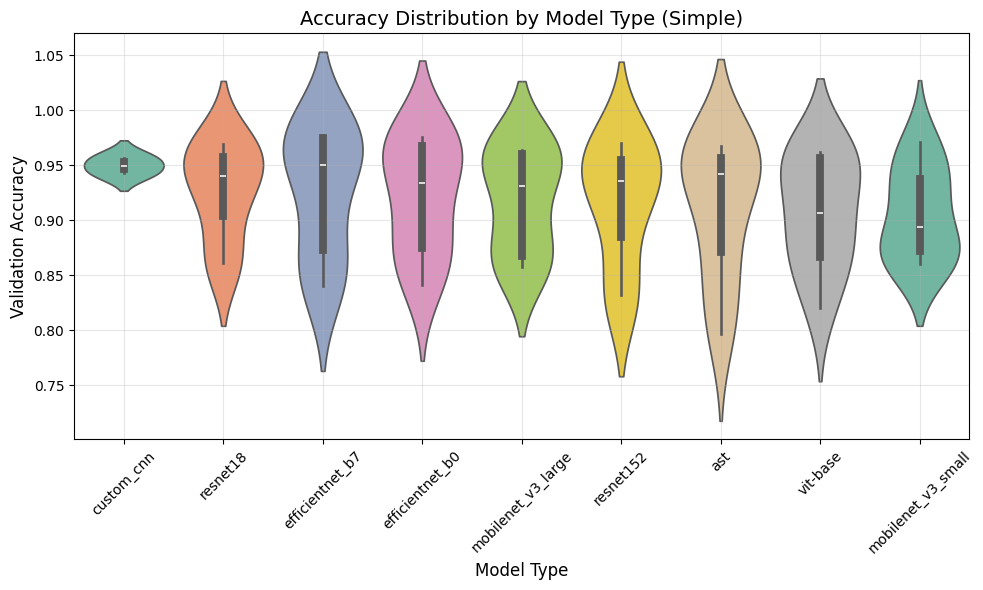

In [15]:
# Simple Plot 1: Accuracy distribution by model type (no annotations)
plt.style.use('default')
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

model_order = get_ordered_categories(plot_df, 'model', 'accuracy')
sns.violinplot(data=plot_df, x='model', y='accuracy', ax=ax, palette='Set2', order=model_order)

ax.set_title('Accuracy Distribution by Model Type (Simple)', fontsize=14)
ax.set_xlabel('Model Type', fontsize=12)
ax.set_ylabel('Validation Accuracy', fontsize=12)
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('simple_accuracy_by_model_type.png', dpi=300, bbox_inches='tight')
plt.show()


/var/folders/wt/0cctqrvs30s8k5gxwkvs86j80000gn/T/ipykernel_25553/1131770764.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=plot_df, x='config_type', y='accuracy', ax=ax, palette='Set1', order=config_order)


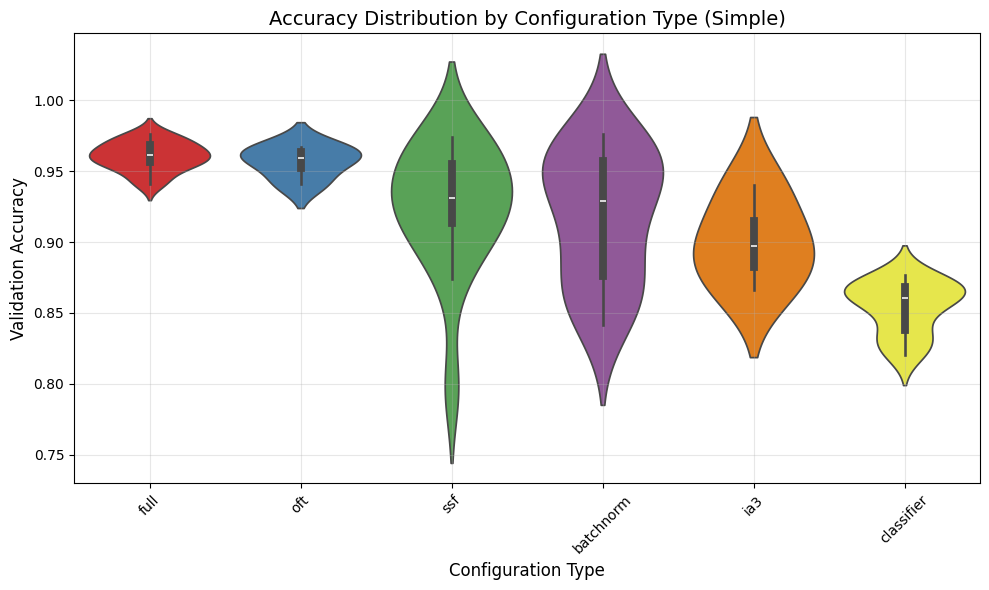

In [16]:
# Simple Plot 2: Accuracy distribution by configuration type (no annotations)
plt.style.use('default')
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

config_order = get_ordered_categories(plot_df, 'config_type', 'accuracy')
sns.violinplot(data=plot_df, x='config_type', y='accuracy', ax=ax, palette='Set1', order=config_order)

ax.set_title('Accuracy Distribution by Configuration Type (Simple)', fontsize=14)
ax.set_xlabel('Configuration Type', fontsize=12)
ax.set_ylabel('Validation Accuracy', fontsize=12)
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('simple_accuracy_by_config_type.png', dpi=300, bbox_inches='tight')
plt.show()


/var/folders/wt/0cctqrvs30s8k5gxwkvs86j80000gn/T/ipykernel_25553/540036225.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=plot_df, x='model', y='std_dev', ax=ax, palette='Set3', order=model_order)


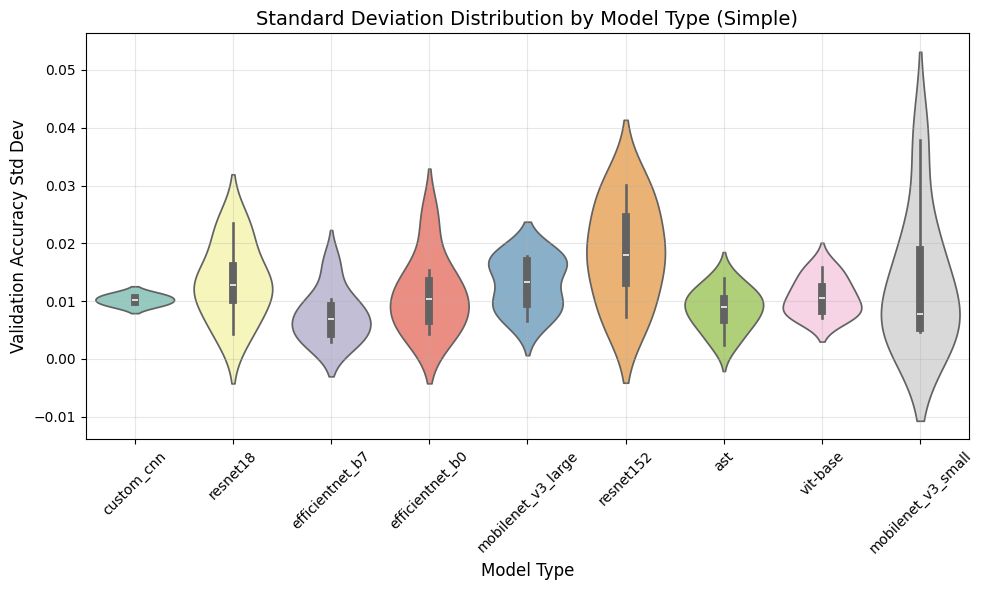

In [17]:
# Simple Plot 3: Standard deviation distribution by model type (no annotations)
plt.style.use('default')
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

model_order = get_ordered_categories(plot_df, 'model', 'accuracy')
sns.violinplot(data=plot_df, x='model', y='std_dev', ax=ax, palette='Set3', order=model_order)

ax.set_title('Standard Deviation Distribution by Model Type (Simple)', fontsize=14)
ax.set_xlabel('Model Type', fontsize=12)
ax.set_ylabel('Validation Accuracy Std Dev', fontsize=12)
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('simple_std_dev_by_model_type.png', dpi=300, bbox_inches='tight')
plt.show()


/var/folders/wt/0cctqrvs30s8k5gxwkvs86j80000gn/T/ipykernel_25553/3206410692.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=plot_df, x='aug_level', y='accuracy', ax=ax, palette='viridis', order=aug_order)


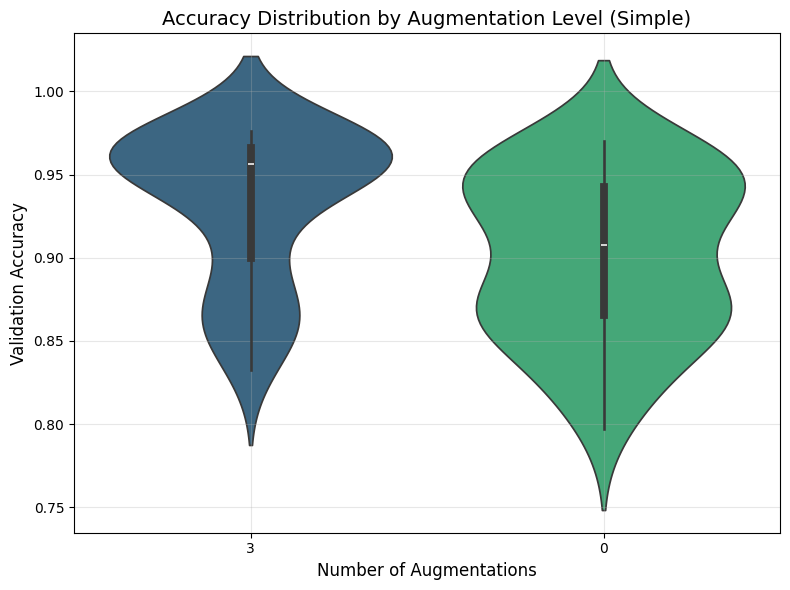

In [18]:
# Simple Plot 4: Accuracy vs augmentation level (no annotations)
plt.style.use('default')
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

aug_order = get_ordered_categories(plot_df, 'aug_level', 'accuracy')
sns.violinplot(data=plot_df, x='aug_level', y='accuracy', ax=ax, palette='viridis', order=aug_order)

ax.set_title('Accuracy Distribution by Augmentation Level (Simple)', fontsize=14)
ax.set_xlabel('Number of Augmentations', fontsize=12)
ax.set_ylabel('Validation Accuracy', fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('simple_accuracy_by_augmentation_level.png', dpi=300, bbox_inches='tight')
plt.show()


/var/folders/wt/0cctqrvs30s8k5gxwkvs86j80000gn/T/ipykernel_25553/3009419910.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=plot_df, x='config_type', y='std_dev', ax=ax, palette='Set1')


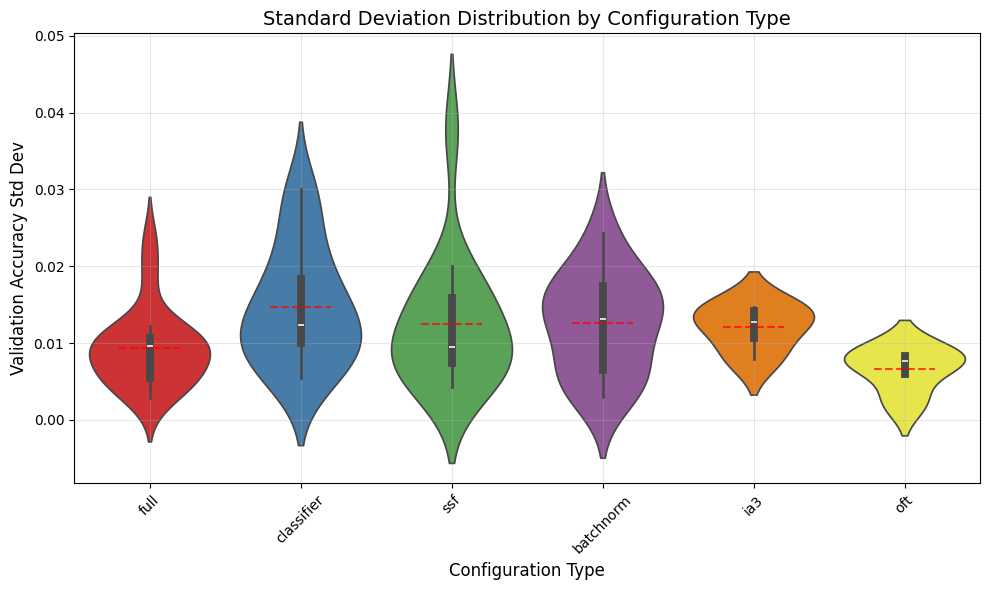

In [19]:
# Standard Deviation Analysis - Plot 1: By Configuration Type
plt.style.use('default')
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

sns.violinplot(data=plot_df, x='config_type', y='std_dev', ax=ax, palette='Set1')
ax.set_title('Standard Deviation Distribution by Configuration Type', fontsize=14)
ax.set_xlabel('Configuration Type', fontsize=12)
ax.set_ylabel('Validation Accuracy Std Dev', fontsize=12)
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3)

# Add mean lines for each configuration type
for i, config in enumerate(plot_df['config_type'].unique()):
    mean_std = plot_df[plot_df['config_type'] == config]['std_dev'].mean()
    ax.axhline(y=mean_std, color='red', linestyle='--', alpha=0.7, 
               xmin=i/len(plot_df['config_type'].unique()) + 0.05, 
               xmax=(i+1)/len(plot_df['config_type'].unique()) - 0.05)

plt.tight_layout()
plt.savefig('std_dev_by_config_type.png', dpi=300, bbox_inches='tight')
plt.show()


/var/folders/wt/0cctqrvs30s8k5gxwkvs86j80000gn/T/ipykernel_25553/777494045.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=plot_df, x='aug_level', y='std_dev', ax=ax, palette='viridis')


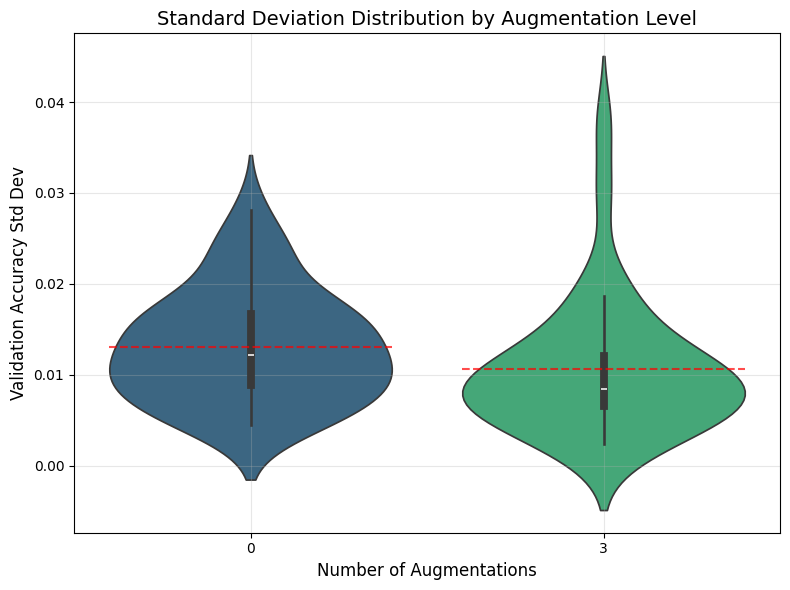

In [20]:
# Standard Deviation Analysis - Plot 2: By Augmentation Level
plt.style.use('default')
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

sns.violinplot(data=plot_df, x='aug_level', y='std_dev', ax=ax, palette='viridis')
ax.set_title('Standard Deviation Distribution by Augmentation Level', fontsize=14)
ax.set_xlabel('Number of Augmentations', fontsize=12)
ax.set_ylabel('Validation Accuracy Std Dev', fontsize=12)
ax.grid(True, alpha=0.3)

# Add mean lines for each augmentation level
for i, aug in enumerate(plot_df['aug_level'].unique()):
    mean_std = plot_df[plot_df['aug_level'] == aug]['std_dev'].mean()
    ax.axhline(y=mean_std, color='red', linestyle='--', alpha=0.7,
               xmin=i/len(plot_df['aug_level'].unique()) + 0.05,
               xmax=(i+1)/len(plot_df['aug_level'].unique()) - 0.05)

plt.tight_layout()
plt.savefig('std_dev_by_augmentation_level.png', dpi=300, bbox_inches='tight')
plt.show()


In [21]:
# Print summary statistics
print("=== SUMMARY STATISTICS ===")
print("\nAccuracy by Model Type:")
print(plot_df.groupby('model')['accuracy'].agg(['mean', 'std', 'min', 'max']).round(4))

print("\nAccuracy by Configuration Type:")
print(plot_df.groupby('config_type')['accuracy'].agg(['mean', 'std', 'min', 'max']).round(4))

print("\nStandard Deviation by Configuration Type:")
print(plot_df.groupby('config_type')['std_dev'].agg(['mean', 'std', 'min', 'max']).round(4))

print("\nAccuracy by Augmentation Level:")
print(plot_df.groupby('aug_level')['accuracy'].agg(['mean', 'std', 'min', 'max']).round(4))


=== SUMMARY STATISTICS ===

Accuracy by Model Type:
                      mean     std     min     max
model                                             
ast                 0.9105  0.0627  0.7971  0.9674
custom_cnn          0.9498  0.0094  0.9432  0.9565
efficientnet_b0     0.9212  0.0524  0.8416  0.9761
efficientnet_b7     0.9250  0.0582  0.8400  0.9765
mobilenet_v3_large  0.9175  0.0475  0.8574  0.9639
mobilenet_v3_small  0.9058  0.0425  0.8603  0.9713
resnet152           0.9156  0.0557  0.8319  0.9706
resnet18            0.9262  0.0432  0.8613  0.9697
vit-base            0.9076  0.0515  0.8203  0.9626

Accuracy by Configuration Type:
               mean     std     min     max
config_type                                
batchnorm    0.9179  0.0464  0.8416  0.9765
classifier   0.8542  0.0185  0.8203  0.8765
full         0.9607  0.0101  0.9410  0.9761
ia3          0.9005  0.0314  0.8665  0.9406
oft          0.9569  0.0114  0.9413  0.9674
ssf          0.9240  0.0455  0.7971  0.9745

S

In [22]:
# Runtime Analysis Setup - Data preparation and helper functions
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert runtime to minutes for better readability
plot_df['runtime_minutes'] = plot_df['runtime'] / 60
plot_df['runtime_hours'] = plot_df['runtime'] / 3600

# Helper function to get ordered categories by mean runtime (ascending - fastest first)
def get_ordered_categories_runtime(df, group_col, value_col):
    order = (
        df.groupby(group_col)[value_col]
        .mean()
        .sort_values(ascending=True)  # Ascending for runtime (fastest first)
        .index
        .tolist()
    )
    return order

# Helper function to add runtime statistics annotations
def add_runtime_stats(ax, df, x_col, y_col, order):
    for i, category in enumerate(order):
        category_data = df[df[x_col] == category][y_col]
        if len(category_data) > 0:
            mean_val = category_data.mean()
            median_val = category_data.median()
            
            # Add mean annotation (blue diamond)
            ax.scatter(i, mean_val, color='blue', marker='D', s=60, zorder=10, alpha=0.8)
            ax.annotate(f'μ:{mean_val:.1f}m', (i, mean_val), 
                       xytext=(5, 15), textcoords='offset points',
                       fontsize=9, color='blue', weight='bold',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='lightblue', alpha=0.7))
            
            # Add median annotation (orange square)
            ax.scatter(i, median_val, color='orange', marker='s', s=50, zorder=10, alpha=0.8)
            ax.annotate(f'M:{median_val:.1f}m', (i, median_val), 
                       xytext=(5, -20), textcoords='offset points',
                       fontsize=9, color='orange', weight='bold',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='lightyellow', alpha=0.7))


/var/folders/wt/0cctqrvs30s8k5gxwkvs86j80000gn/T/ipykernel_25553/3077649517.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=plot_df, x='model', y='runtime_minutes', ax=ax, palette='Set2', order=model_order_runtime)


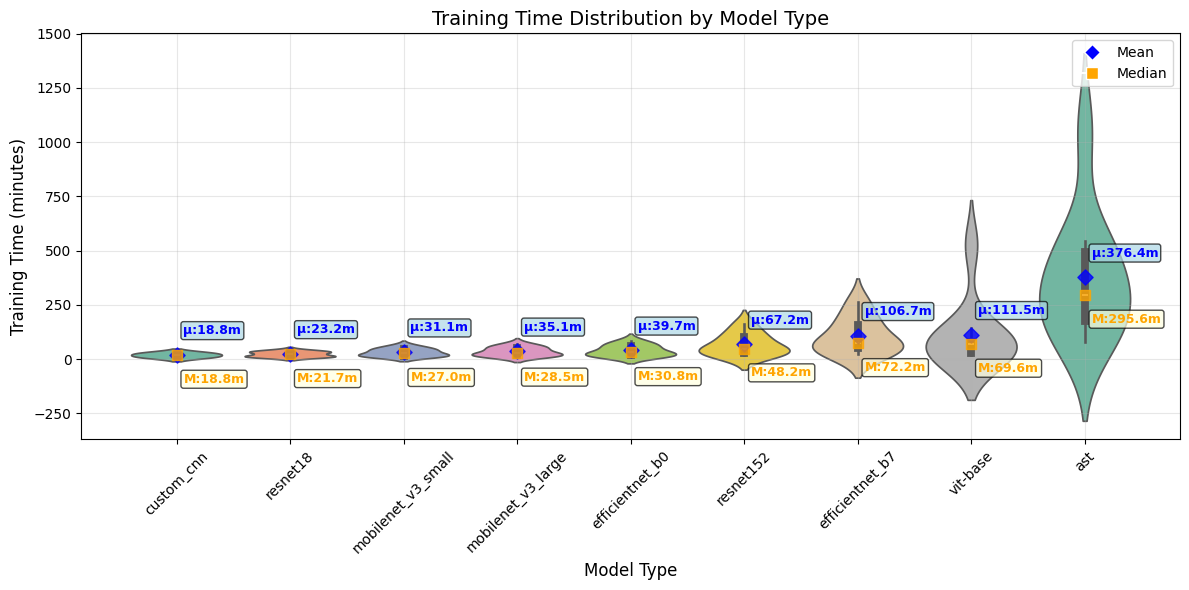

In [23]:
# Runtime Plot 1: Training time distribution by model type
plt.style.use('default')
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

model_order_runtime = get_ordered_categories_runtime(plot_df, 'model', 'runtime_minutes')
sns.violinplot(data=plot_df, x='model', y='runtime_minutes', ax=ax, palette='Set2', order=model_order_runtime)
add_runtime_stats(ax, plot_df, 'model', 'runtime_minutes', model_order_runtime)

ax.set_title('Training Time Distribution by Model Type', fontsize=14)
ax.set_xlabel('Model Type', fontsize=12)
ax.set_ylabel('Training Time (minutes)', fontsize=12)
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3)

# Add legend for statistics markers
legend_elements = [
    plt.Line2D([0], [0], marker='D', color='w', markerfacecolor='blue', markersize=8, label='Mean'),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='orange', markersize=8, label='Median')
]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.savefig('runtime_by_model_type.png', dpi=300, bbox_inches='tight')
plt.show()


/var/folders/wt/0cctqrvs30s8k5gxwkvs86j80000gn/T/ipykernel_25553/1124888045.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=plot_df, x='config_type', y='runtime_minutes', ax=ax, palette='Set1', order=config_order_runtime)


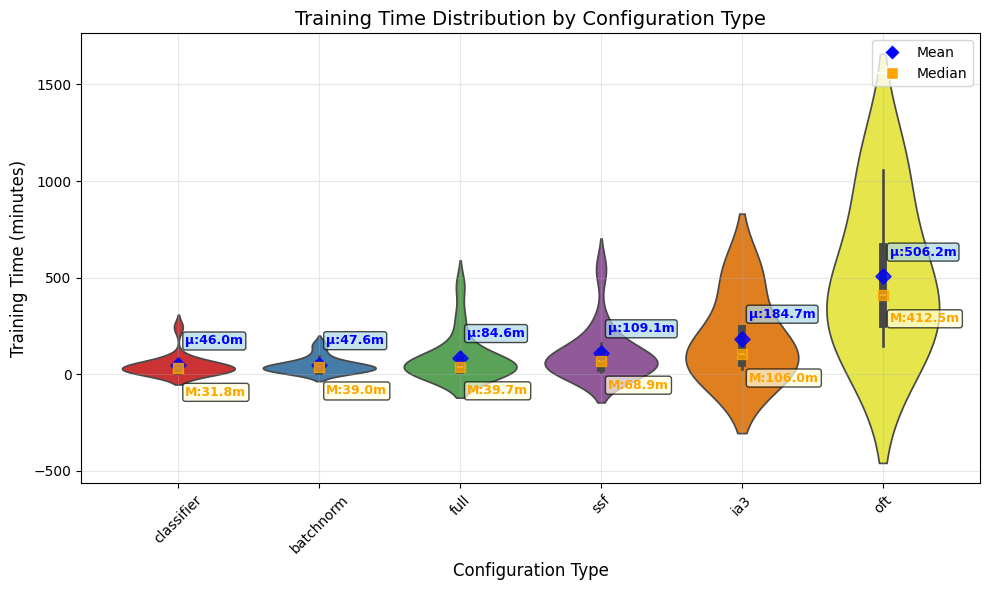

In [24]:
# Runtime Plot 2: Training time distribution by configuration type
plt.style.use('default')
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

config_order_runtime = get_ordered_categories_runtime(plot_df, 'config_type', 'runtime_minutes')
sns.violinplot(data=plot_df, x='config_type', y='runtime_minutes', ax=ax, palette='Set1', order=config_order_runtime)
add_runtime_stats(ax, plot_df, 'config_type', 'runtime_minutes', config_order_runtime)

ax.set_title('Training Time Distribution by Configuration Type', fontsize=14)
ax.set_xlabel('Configuration Type', fontsize=12)
ax.set_ylabel('Training Time (minutes)', fontsize=12)
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3)

# Add legend for statistics markers
legend_elements = [
    plt.Line2D([0], [0], marker='D', color='w', markerfacecolor='blue', markersize=8, label='Mean'),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='orange', markersize=8, label='Median')
]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.savefig('runtime_by_config_type.png', dpi=300, bbox_inches='tight')
plt.show()


/var/folders/wt/0cctqrvs30s8k5gxwkvs86j80000gn/T/ipykernel_25553/3071859121.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=plot_df, x='aug_level', y='runtime_minutes', ax=ax, palette='viridis', order=aug_order_runtime)


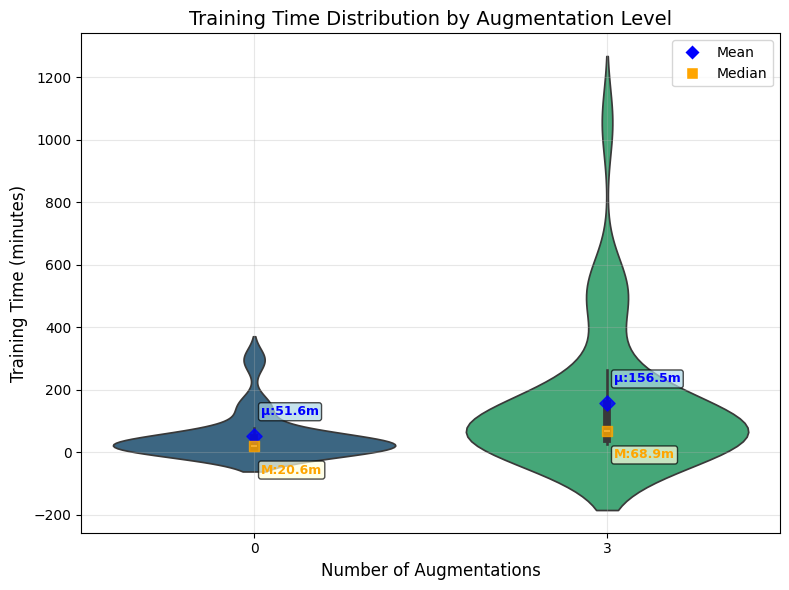

In [25]:
# Runtime Plot 3: Training time distribution by augmentation level
plt.style.use('default')
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

aug_order_runtime = get_ordered_categories_runtime(plot_df, 'aug_level', 'runtime_minutes')
sns.violinplot(data=plot_df, x='aug_level', y='runtime_minutes', ax=ax, palette='viridis', order=aug_order_runtime)
add_runtime_stats(ax, plot_df, 'aug_level', 'runtime_minutes', aug_order_runtime)

ax.set_title('Training Time Distribution by Augmentation Level', fontsize=14)
ax.set_xlabel('Number of Augmentations', fontsize=12)
ax.set_ylabel('Training Time (minutes)', fontsize=12)
ax.grid(True, alpha=0.3)

# Add legend for statistics markers
legend_elements = [
    plt.Line2D([0], [0], marker='D', color='w', markerfacecolor='blue', markersize=8, label='Mean'),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='orange', markersize=8, label='Median')
]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.savefig('runtime_by_augmentation_level.png', dpi=300, bbox_inches='tight')
plt.show()


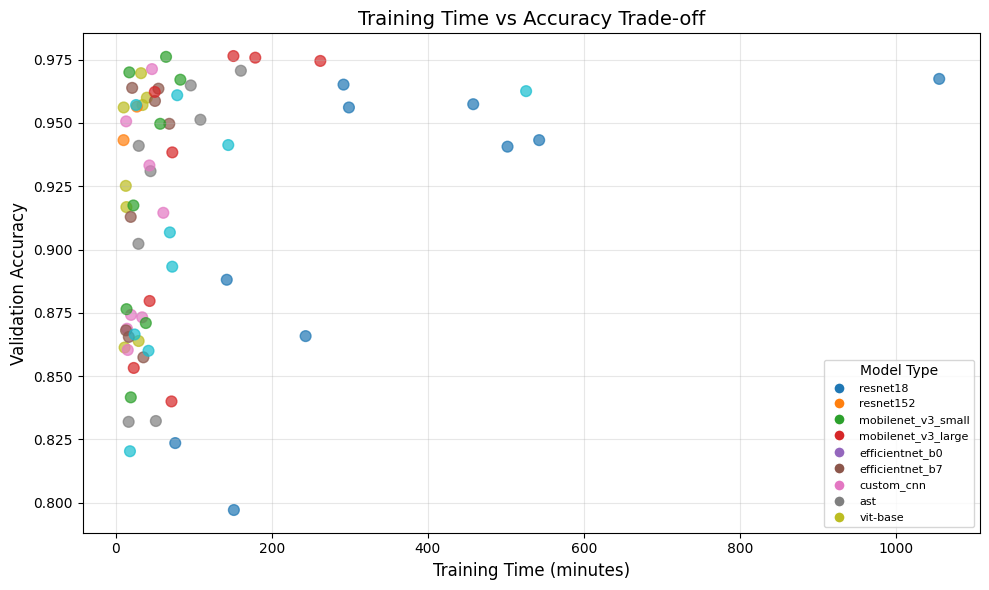

In [35]:
# Runtime Plot 4: Training time vs accuracy scatter plot
plt.style.use('default')
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

scatter = ax.scatter(plot_df['runtime_minutes'], plot_df['accuracy'], 
                     c=pd.Categorical(plot_df['model']).codes, 
                     cmap='tab10', alpha=0.7, s=60)

ax.set_title('Training Time vs Accuracy Trade-off', fontsize=14)
ax.set_xlabel('Training Time (minutes)', fontsize=12)
ax.set_ylabel('Validation Accuracy', fontsize=12)
ax.grid(True, alpha=0.3)

# Add colorbar for model types
unique_models = plot_df['model'].unique()
handles = [plt.Line2D([0], [0], marker='o', color='w', 
                     markerfacecolor=plt.cm.tab10(i/len(unique_models)), 
                     markersize=8, label=model) 
          for i, model in enumerate(unique_models)]
ax.legend(handles=handles, loc='lower right', fontsize=8, title='Model Type')

plt.tight_layout()
plt.savefig('runtime_vs_accuracy_scatter.png', dpi=300, bbox_inches='tight')
plt.show()


In [27]:
# Detailed Runtime Statistics and Efficiency Analysis
print("=== RUNTIME PERFORMANCE STATISTICS ===")
print(f"Total runtime across all experiments: {total_runtime}")
print(f"Total runtime in hours: {total_seconds/3600:.2f} hours")
print(f"Average runtime per experiment: {plot_df['runtime_minutes'].mean():.2f} minutes")
print(f"Median runtime per experiment: {plot_df['runtime_minutes'].median():.2f} minutes")

print("\n=== RUNTIME BY MODEL TYPE ===")
runtime_by_model = plot_df.groupby('model')['runtime_minutes'].agg(['mean', 'median', 'std', 'min', 'max', 'count']).round(2)
runtime_by_model = runtime_by_model.sort_values('mean')  # Sort by mean runtime (fastest first)
print(runtime_by_model)

print("\n=== RUNTIME BY CONFIGURATION TYPE ===")
runtime_by_config = plot_df.groupby('config_type')['runtime_minutes'].agg(['mean', 'median', 'std', 'min', 'max', 'count']).round(2)
runtime_by_config = runtime_by_config.sort_values('mean')
print(runtime_by_config)

print("\n=== RUNTIME BY AUGMENTATION LEVEL ===")
runtime_by_aug = plot_df.groupby('aug_level')['runtime_minutes'].agg(['mean', 'median', 'std', 'min', 'max', 'count']).round(2)
runtime_by_aug = runtime_by_aug.sort_values('mean')
print(runtime_by_aug)

print("\n=== EFFICIENCY METRICS (Accuracy per Minute) ===")
plot_df['efficiency'] = plot_df['accuracy'] / plot_df['runtime_minutes']
efficiency_by_model = plot_df.groupby('model')['efficiency'].agg(['mean', 'median', 'std']).round(6)
efficiency_by_model = efficiency_by_model.sort_values('mean', ascending=False)  # Sort by efficiency (best first)
print("Efficiency by Model Type (Accuracy/Minute):")
print(efficiency_by_model)

efficiency_by_config = plot_df.groupby('config_type')['efficiency'].agg(['mean', 'median', 'std']).round(6)
efficiency_by_config = efficiency_by_config.sort_values('mean', ascending=False)
print("\nEfficiency by Configuration Type (Accuracy/Minute):")
print(efficiency_by_config)

# Find the most efficient runs
print("\n=== TOP 10 MOST EFFICIENT RUNS ===")
top_efficient = plot_df.nlargest(10, 'efficiency')[['model', 'config_type', 'aug_level', 'accuracy', 'runtime_minutes', 'efficiency']]
print(top_efficient.round(4))

# Find the fastest runs
print("\n=== TOP 10 FASTEST RUNS ===")
fastest_runs = plot_df.nsmallest(10, 'runtime_minutes')[['model', 'config_type', 'aug_level', 'accuracy', 'runtime_minutes', 'efficiency']]
print(fastest_runs.round(4))


=== RUNTIME PERFORMANCE STATISTICS ===
Total runtime across all experiments: 5 days, 0:55:28.362073
Total runtime in hours: 120.92 hours
Average runtime per experiment: 104.79 minutes
Median runtime per experiment: 43.63 minutes

=== RUNTIME BY MODEL TYPE ===
                      mean  median     std    min      max  count
model                                                            
custom_cnn           18.77   18.77   12.04  10.26    27.29      2
resnet18             23.24   21.73   12.13  10.43    40.12      8
mobilenet_v3_small   31.13   26.96   17.94  13.59    61.21      8
mobilenet_v3_large   35.14   28.47   20.72  13.41    68.85      8
efficientnet_b0      39.73   30.83   25.76  14.07    83.03      8
resnet152            67.25   48.23   49.88  16.79   160.55      8
efficientnet_b7     106.75   72.19   82.74  23.32   262.37      8
vit-base            111.46   69.59  160.29  18.48   526.04      9
ast                 376.38  295.56  286.19  76.48  1055.34     10

=== RUNTIME B

In [28]:
# Advanced Runtime Analysis Setup - Create pivot tables for heatmaps
runtime_pivot = plot_df.pivot_table(values='runtime_minutes', index='model', columns='config_type', aggfunc='mean')
accuracy_pivot = plot_df.pivot_table(values='accuracy', index='model', columns='config_type', aggfunc='mean')
efficiency_pivot = plot_df.pivot_table(values='efficiency', index='model', columns='config_type', aggfunc='mean')

print("Pivot tables created for advanced runtime analysis")


Pivot tables created for advanced runtime analysis


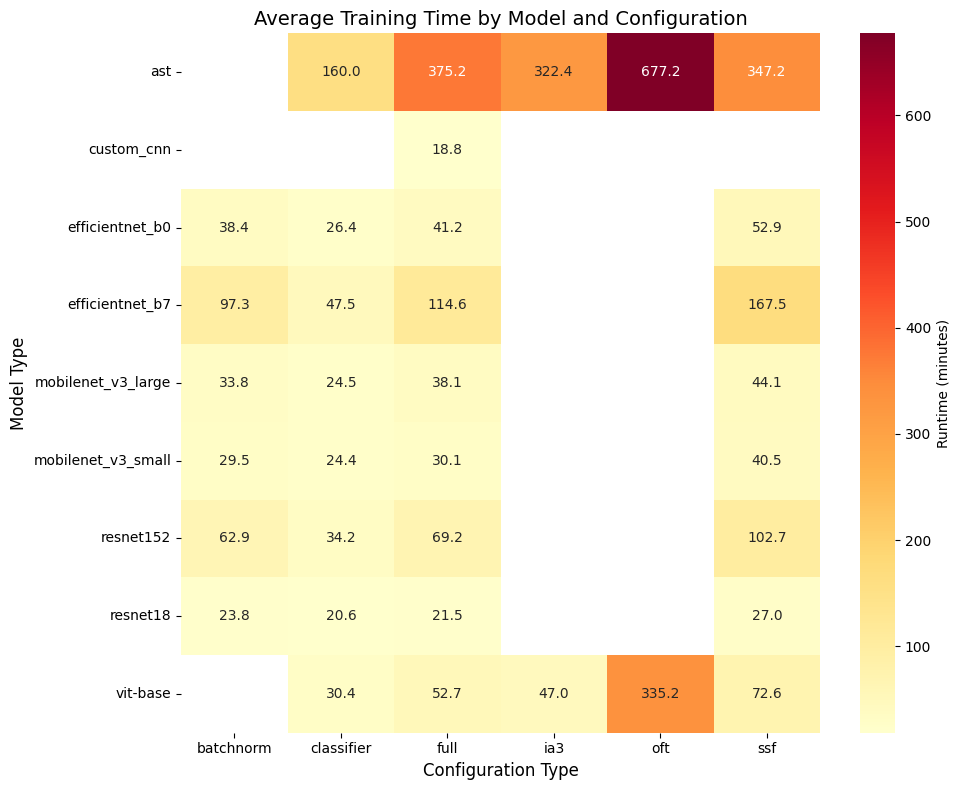

In [29]:
# Advanced Plot 1: Runtime heatmap by model and configuration type
plt.style.use('default')
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

sns.heatmap(runtime_pivot, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax, cbar_kws={'label': 'Runtime (minutes)'})
ax.set_title('Average Training Time by Model and Configuration', fontsize=14)
ax.set_xlabel('Configuration Type', fontsize=12)
ax.set_ylabel('Model Type', fontsize=12)

plt.tight_layout()
plt.savefig('runtime_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()


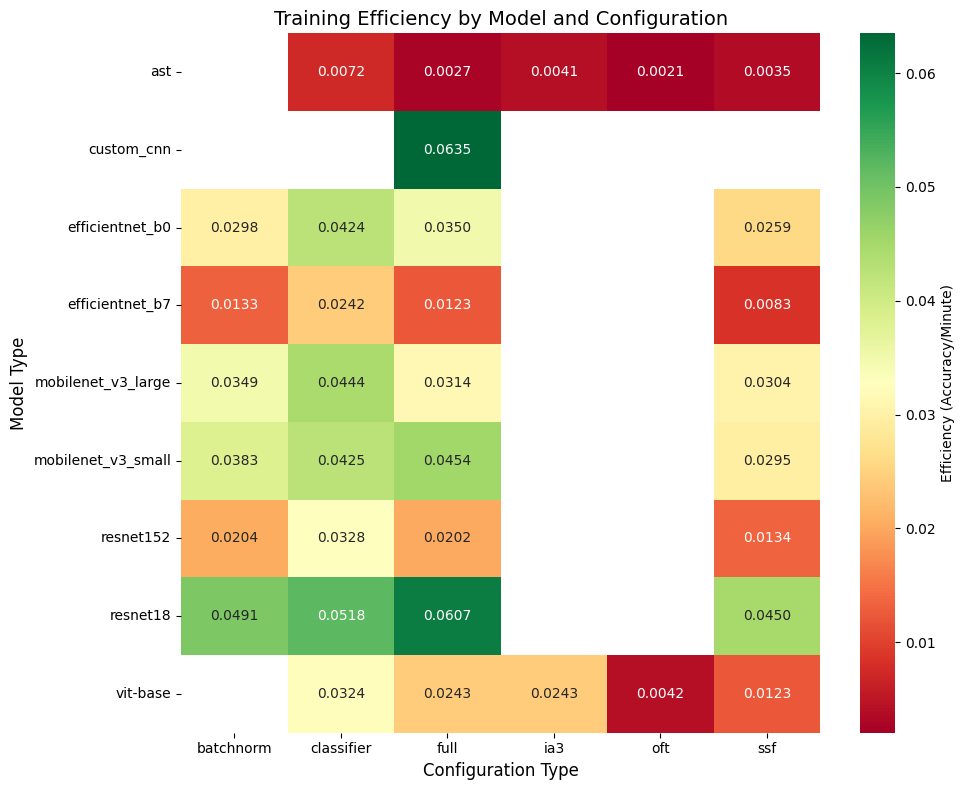

In [30]:
# Advanced Plot 2: Efficiency heatmap by model and configuration type
plt.style.use('default')
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

sns.heatmap(efficiency_pivot, annot=True, fmt='.4f', cmap='RdYlGn', ax=ax, cbar_kws={'label': 'Efficiency (Accuracy/Minute)'})
ax.set_title('Training Efficiency by Model and Configuration', fontsize=14)
ax.set_xlabel('Configuration Type', fontsize=12)
ax.set_ylabel('Model Type', fontsize=12)

plt.tight_layout()
plt.savefig('efficiency_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()


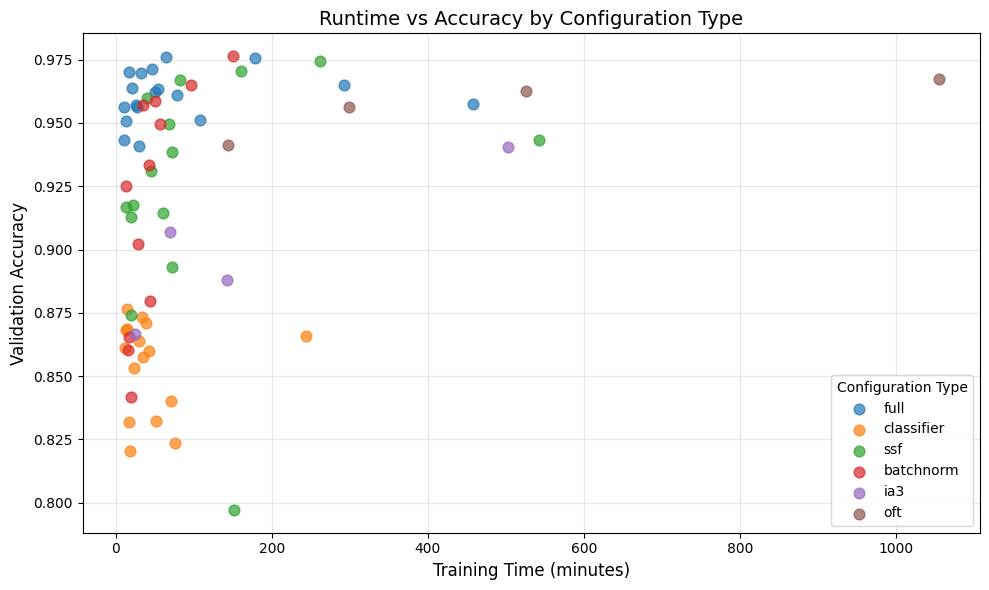

In [31]:
# Advanced Plot 3: Runtime vs accuracy scatter by configuration type
plt.style.use('default')
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for config in plot_df['config_type'].unique():
    config_data = plot_df[plot_df['config_type'] == config]
    ax.scatter(config_data['runtime_minutes'], config_data['accuracy'], 
               label=config, alpha=0.7, s=60)

ax.set_xlabel('Training Time (minutes)', fontsize=12)
ax.set_ylabel('Validation Accuracy', fontsize=12)
ax.set_title('Runtime vs Accuracy by Configuration Type', fontsize=14)
ax.legend(title='Configuration Type', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('runtime_vs_accuracy_by_config.png', dpi=300, bbox_inches='tight')
plt.show()


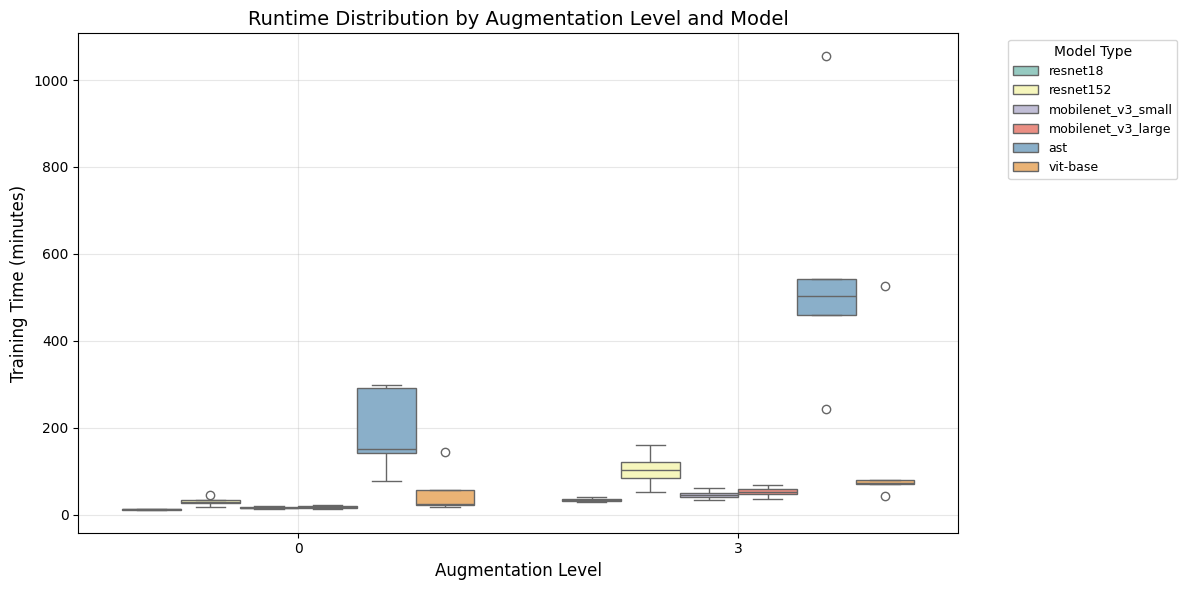

In [32]:
# Advanced Plot 4: Box plot of runtime distribution by model and augmentation level
plt.style.use('default')
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Create a combined category for better visualization
plot_df['model_aug'] = plot_df['model'] + ' (' + plot_df['aug_level'].astype(str) + ' augs)'

# Select top models by frequency for readability
top_models = plot_df['model'].value_counts().head(6).index
filtered_df = plot_df[plot_df['model'].isin(top_models)]

sns.boxplot(data=filtered_df, x='aug_level', y='runtime_minutes', hue='model', ax=ax, palette='Set3')
ax.set_title('Runtime Distribution by Augmentation Level and Model', fontsize=14)
ax.set_xlabel('Augmentation Level', fontsize=12)
ax.set_ylabel('Training Time (minutes)', fontsize=12)
ax.legend(title='Model Type', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('runtime_boxplot_by_model_aug.png', dpi=300, bbox_inches='tight')
plt.show()
